# Simple MAD

This notebook shows the simplest possible MAD: a two pixel image, where our models are L2-norm and L1-norm. It will not explain the basics of MAD Competition or how to use it. Instead, since we're dealing with a simple and low-dimensional example, we can plot the image in pixel space and draw out the model contours, which we can use to explicitly check whether we've found the correct results.

In [1]:
import plenoptic as po
from plenoptic.tools import to_numpy
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
import numpy as np
import itertools

%load_ext autoreload
%autoreload 2

First we pick our metrics and run our synthesis. We create four different `MADCompetition` instances, in order to create the full set of images.

In [2]:
img = torch.tensor([.5, .5], dtype=torch.float32).reshape((1, 1, 1, 2))
def l1_norm(x, y):
    return torch.norm(x-y, 1)
metrics = [po.tools.optim.l2_norm, l1_norm]
all_mad = {}

# this gets us all four possibilities
for t, (m1, m2) in itertools.product(['min', 'max'], zip(metrics, metrics[::-1])):
    name = f'{m1.__name__}_{t}'
    # we set the seed like this to ensure that all four MADCompetition instances have the same initial_signal. Try different seed values! 
    po.tools.set_seed(4)
    all_mad[name] = po.synth.MADCompetition(img, m1, m2, t, metric_tradeoff_lambda=1e4)
    optim = torch.optim.Adam([all_mad[name].synthesized_signal], lr=.0001)
    print(f"Synthesizing {name}")
    all_mad[name].synthesize(store_progress=True, max_iter=1500, optimizer=optim)

# double-check that these are all equal.
assert all([torch.allclose(all_mad['l2_norm_min'].initial_signal, v.initial_signal) for v in all_mad.values()])

Synthesizing l2_norm_min


  0%|          | 0/1500 [00:00<?, ?it/s]

Synthesizing l1_norm_min


  0%|          | 0/1500 [00:00<?, ?it/s]

Synthesizing l2_norm_max


  0%|          | 0/1500 [00:00<?, ?it/s]

Synthesizing l1_norm_max


  0%|          | 0/1500 [00:00<?, ?it/s]

(The red progress bars show that we hit our stop criterion and broke out of the loop early, not that anything went wrong.)

Now let's visualize our metrics for these four instances:

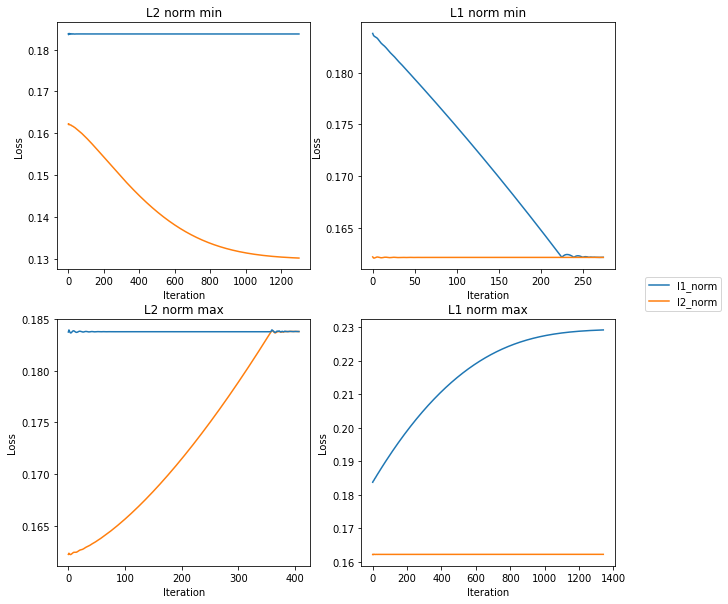

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
pal = {'l1_norm': 'C0', 'l2_norm': 'C1'}
for ax, (k, mad) in zip(axes.flatten(), all_mad.items()):
    ax.plot(mad.synthesis_metric_loss, pal[mad.synthesis_metric.__name__], label=mad.synthesis_metric.__name__)
    ax.plot(mad.fixed_metric_loss, pal[mad.fixed_metric.__name__], label=mad.fixed_metric.__name__)
    ax.set(title=k.capitalize().replace('_', ' '), xlabel='Iteration', ylabel='Loss')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 1.1))

This looks pretty good -- the L1 norm line is flat in the left column, while the L2 norm is flat in the right column, and the other line is either rising (in the bottom row) or falling (in the top).

Since our images only have two pixels, we can get a better sense of what's going on by plotting them in pixel space: first pixel value on the x-axis, second on the y-axis. We can use this to visualize the points and how far they are from each other. We also know what the level curves look like for the $L_1$ and $L_2$ norms (a diamond and a circle centered on our reference image, respectively), so we can add them as well.

In [4]:
l1 = to_numpy(torch.norm(all_mad['l2_norm_max'].reference_signal - all_mad['l2_norm_max'].initial_signal, 1))
l2 = to_numpy(torch.norm(all_mad['l2_norm_max'].reference_signal - all_mad['l2_norm_max'].initial_signal, 2))
ref = to_numpy(all_mad['l2_norm_max'].reference_signal.squeeze())
init = to_numpy(all_mad['l2_norm_max'].initial_signal.squeeze())

def circle(origin, r, n=1000):
    theta = 2*np.pi/n*np.arange(0, n+1)
    return np.array([origin[1]+r*np.cos(theta), origin[0]+r*np.sin(theta)])
def diamond(origin, r, n=1000):
    theta = 2*np.pi/n*np.arange(0, n+1)
    rotation = np.pi/4
    square_correction = (np.abs(np.cos(theta-rotation)-np.sin(theta-rotation)) + np.abs(np.cos(theta-rotation)+np.sin(theta-rotation)))
    square_correction /= square_correction[0]
    r = r / square_correction
    return np.array([origin[1]+r*np.cos(theta), origin[0]+r*np.sin(theta)])
l2_level_set = circle(ref, l2,)
l1_level_set = diamond(ref, l1)

We can see in the following plot that it is doing the right thing, but it's very hard to separate these two metrics. We've styled the points below so that their color matches the contour level they're supposed to lie on (i.e., the fixed metric), and so that a hollow point shows the target was to minimize, and a solid one to maximize.

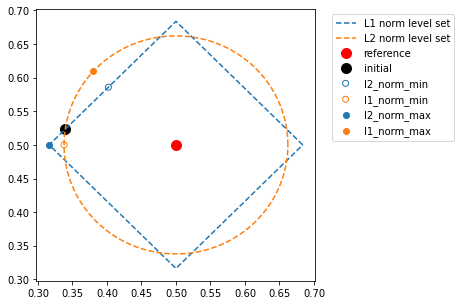

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(*ref, label='reference', c='r', s=100)
ax.scatter(*init, label='initial', c='k', s=100)
ax.plot(*l1_level_set, pal['l1_norm']+'--', label='L1 norm level set')
ax.plot(*l2_level_set, pal['l2_norm']+'--', label='L2 norm level set')
for k, v in all_mad.items():
    ec = pal[v.fixed_metric.__name__]
    fc = 'none' if 'min' in k else ec
    ax.scatter(*v.synthesized_signal.squeeze().detach(), fc=fc, ec=ec, label=k)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

Generally, you're working with metrics where you can't make the above plot to double-check the performance of MAD. Unfortunately, you'll have to spend time playing with the various parameters in order to find what works best. The most important of these parameters is `metric_tradeoff_lambda`; you can see above that we set it to the very high value of `1e4` (if you try reducing this yourself, you'll see the fixed metric doesn't stay constant and the points in the bottom plot move towards the reference point in the center). In this case, all four values took the same value of `metric_tradeoff_lambda`, but in general that might not be true (for example, if one of your metrics returns much larger values than the other).

We can also visualize these as images, though it's not particularly helpful in this case.

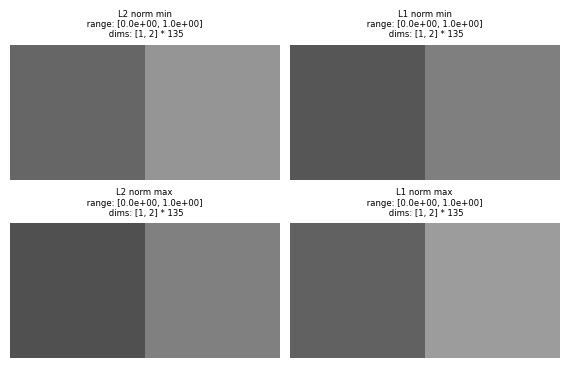

In [6]:
po.imshow([v.synthesized_signal for v in all_mad.values()], zoom=135, vrange=(0, 1), 
          title=[k.capitalize().replace('_', ' ') for k in all_mad.keys()], col_wrap=2);